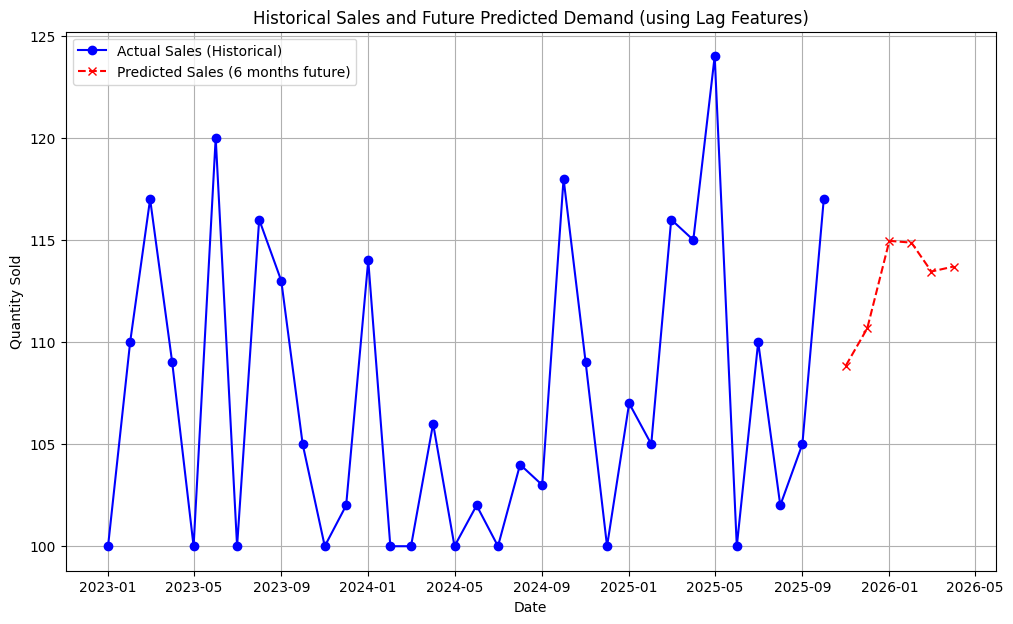

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# --- Step 1: Load and Clean Data ---
# Assuming you have a 'Historical_Sales.csv' file with 'Month', 'Year', 'QuantitySold' columns
try:
    data = pd.read_csv('Historical_Sales1.csv')
    df = pd.DataFrame(data)  
except FileNotFoundError:
    print("Error: Historical_Sales.csv not found.")
    print("Please create the CSV file with the sample data provided previously.")
    exit()

df = df.replace(' ', np.nan)
df['QuantitySold'] = pd.to_numeric(df['QuantitySold'], errors='coerce')
df.dropna(inplace=True)
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(day=1))
df.set_index('Date', inplace=True)

# --- Step 2: Feature Engineering with Lag Features ---
# We will create these features in a function to reuse for future predictions
def engineer_features(dataframe, drop_na=True):
    temp_df = dataframe.copy()
    # Create Lag 1 feature (Sales from the previous month)
    temp_df['Sales_Lag1'] = temp_df['QuantitySold'].shift(1)
    # Create Lag 12 feature (Sales from the same month last year)
    temp_df['Sales_Lag12'] = temp_df['QuantitySold'].shift(12)
    # Add Year as a feature (forward fill year might be needed in future dates)
    temp_df['Year'] = temp_df.index.year.astype(float) 

    if drop_na:
        # Used only for initial training set creation
        return temp_df.dropna()
    else:
        # Used inside the iterative loop where we expect NaNs initially
        return temp_df

# Apply feature engineering to the full historical data for training purposes
df_featured = engineer_features(df, drop_na=True)

# --- Step 3: Define Features and Target ---
FEATURES = ["Sales_Lag1", "Sales_Lag12", "Year"]
TARGET = "QuantitySold"

X = df_featured[FEATURES]
y = df_featured[TARGET]

# --- Step 4: Train the Linear regression model ---
model = LinearRegression()
model.fit(X, y) 

# --- Step 5: Generate Future Predictions Iteratively ---

def generate_future_predictions(model, historical_df, months_to_predict):
    # Start the future predictions from the month *after* the last known date
    future_start_date = historical_df.index.max() + pd.DateOffset(months=1)
    
    # Initialize a temporary DF to hold the new predictions and current lags
    future_dates = pd.date_range(start=future_start_date, periods=months_to_predict, freq='MS')
    temp_future_df = pd.DataFrame(index=future_dates)
    temp_future_df['QuantitySold'] = np.nan # This column will store predictions
    
    # Combine history and future placeholder to easily manage lag features
    combined_df = pd.concat([historical_df, temp_future_df])
    
    # Iterate month by month to predict the next value and update the lag features
    for i in range(months_to_predict):
        current_date = future_dates[i]
        
        # Calculate features without dropping NA this time
        combined_features_all = engineer_features(combined_df, drop_na=False)
        
        # Get the feature row for the current date we want to predict (it will have NaNs for future y, but valid Lags based on history)
        X_current = combined_features_all.loc[[current_date]][FEATURES]
        
        # Ensure that X_current does not have any NaNs in the feature columns used for prediction
        if X_current.isnull().any().any():
             raise ValueError(f"Missing lag data for date {current_date}. Need at least 12 months of history to start prediction.")
             
        # Predict the value for the current date
        predicted_value = model.predict(X_current)[0]
        
        # Store the prediction in the combined DataFrame so the next iteration can use it as a lag feature
        # We use .at for faster single-value access/setting
        combined_df.at[current_date, 'QuantitySold'] = predicted_value
        
    # Extract just the future predictions DataFrame
    future_predictions_df = combined_df[future_start_date:]
    return future_predictions_df

# Generate predictions for the next 6 months
future_predictions_df = generate_future_predictions(model, df, months_to_predict=6)


# --- Step 6: Visualization ---
plt.figure(figsize=(12, 7))

# Plot historical actual sales (full dataset)
plt.plot(df.index, df['QuantitySold'], label='Actual Sales (Historical)', color='blue', marker='o')

# Plot predicted sales for the future period
plt.plot(future_predictions_df.index, future_predictions_df['QuantitySold'], label=f'Predicted Sales ({len(future_predictions_df)} months future)', linestyle='--', marker='x', color='red')

plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.title(f'Historical Sales and Future Predicted Demand (using Lag Features)')
plt.legend()
plt.grid(True)
plt.show()
